# Objective

Produce the same plot as in persistence_analysis_annotators.ipynb but with a shared and normalized x axis.

In [1]:
import os, sys, math
sys.path.insert(0, '../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [2]:
num_spots_list = np.arange(50, 250, 25)
cwd = os.getcwd()

In [3]:
TPR_list, FPR_list, num_annotators_list = [], [], []
    
for num_spots in num_spots_list:
    json_filepath = cwd+ '/annotations/' + 'snr10_' + str(num_spots) + '.json'
    img_filename = 'snr_10_numspots_' + str(num_spots) + '_spot_img.png'
    img_filepath = cwd + '/spot_images/' + img_filename
    csv_filepath = cwd + '/spot_data/' + 'snr_10_numspots_' + str(num_spots) + '_coord_snr_list.csv'
    qa = QuantiusAnnotation(json_filepath, img_filename)
    sa = SpotAnnotationAnalysis(qa)
    anno_all = qa.df()

    clustering_params = ['AffinityPropagation', -350]
    clusters = sa.get_clusters(anno_all, clustering_params)

    img_height = anno_all['height'].values[0]
    centroid_and_ref_df = util.centroid_and_ref_df(clusters, csv_filepath, img_height)

    """ Screen by Cluster Size """
    cluster_size_threshold = util.get_cluster_size_threshold(clusters)
    small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)

    """ Detect Clumps """
    clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
    clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)

    """ Declump """
    declumping_params = ['KMeans', 2]
    result_clusters = nonclumpy_clusters
    for i in range(len(clumpy_clusters.index)):
        subclusters = util.declump(clumpy_clusters, i, declumping_params)
        result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

    """ Find out how many unique annotators per spot """
    result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
    result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points

    ref_df = pd.read_csv(csv_filepath)
    ref_points = ref_df.loc[:, ['col', 'row']].as_matrix().tolist()

    num_annotators = []
    for point in ref_points:
        dist, ind = result_kdt.query([[point[0], 300-point[1]]], k=1)
        if dist[0][0] <= 4:
            row = result_clusters.iloc[[ind[0][0]]]
            members = row.iloc[0]['members']
            uid_list = [member[3] for member in members]
            unique_uid_list = np.unique(uid_list)
            num_annotators.append(len(unique_uid_list))
        else:
            num_annotators.append(0)
    num_annotators_list.append(num_annotators)

    """ FPR and TPR """        
    tpr, fpr = util.calc_fpr_tpr(clusters=result_clusters, csv_filepath=csv_filepath)
    TPR_list.append(tpr)
    FPR_list.append(fpr)


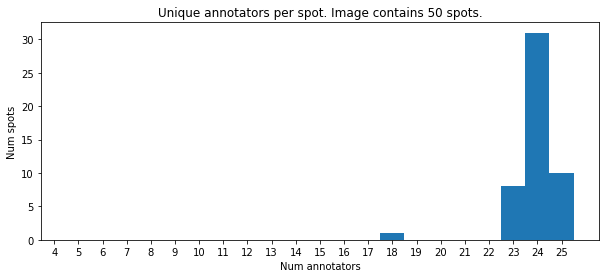

Recall = TPR:		1.0
Precision = 1 - FPR:	1.0


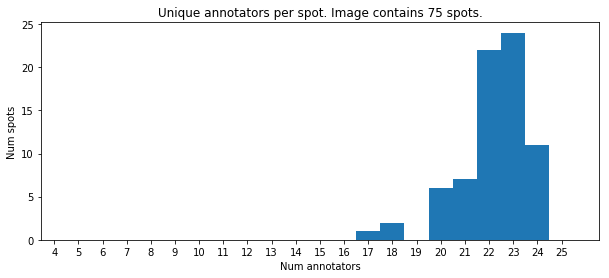

Recall = TPR:		0.97
Precision = 1 - FPR:	1.0


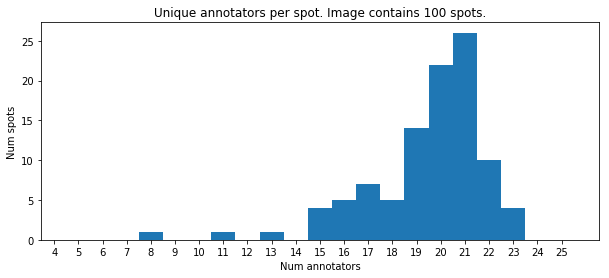

Recall = TPR:		1.0
Precision = 1 - FPR:	1.0


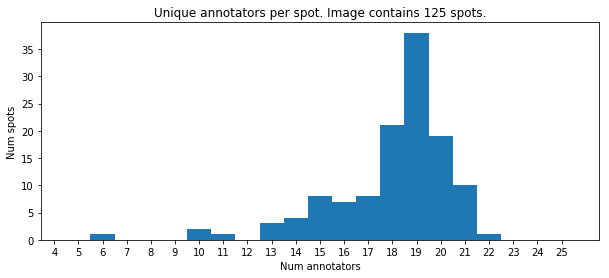

Recall = TPR:		0.98
Precision = 1 - FPR:	0.99


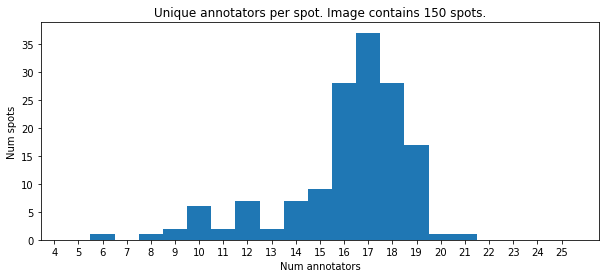

Recall = TPR:		0.99
Precision = 1 - FPR:	1.0


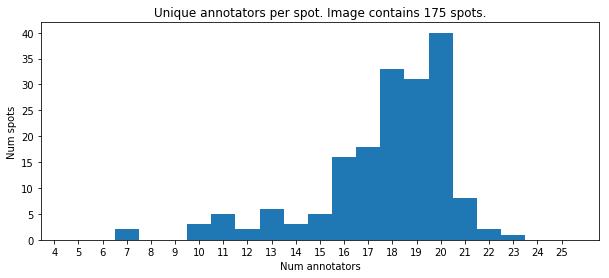

Recall = TPR:		1.0
Precision = 1 - FPR:	0.99


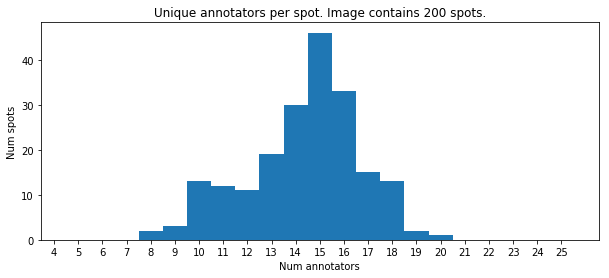

Recall = TPR:		1.0
Precision = 1 - FPR:	0.99


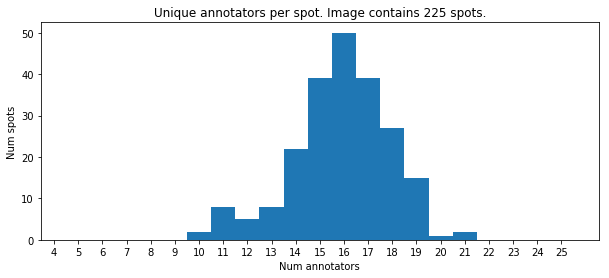

Recall = TPR:		0.97
Precision = 1 - FPR:	0.99


In [20]:
for tpr, fpr, num_annotators, num_spots in zip(TPR_list, FPR_list, num_annotators_list, num_spots_list):
    fig = plt.figure(figsize = (10,4))
    plt.hist(num_annotators, bins=np.arange(4.5, 26.5, 1))
    plt.xticks(np.arange(4, 26, 1))
    plt.title('Unique annotators per spot. Image contains ' + str(num_spots) + ' spots.')
    plt.xlabel('Num annotators')
    plt.ylabel('Num spots')
    plt.show()
    print('Recall = TPR:\t\t' + str(round(tpr, 2)))
    print('Precision = 1 - FPR:\t' + str(round(1-fpr, 2)))